In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import joblib
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [100]:
df = pd.read_csv('data/maintenance.csv')

In [101]:
df.head()

,Robot_ID,Arm_Sensor,Vibration_Sensor,Temperature_Sensor,Pressure_Sensor
0,1,37.4500,6.9800,38.5100,156.2100
1,2,95.0700,5.3600,74.1900,144.2800
2,3,73.2000,3.1000,107.2900,8.6700
3,4,59.8700,8.1400,93.2200,103.0300
4,5,15.6000,6.8500,100.6600,114.6800


In [102]:
print(f"Shape: {df.shape}")

Shape: (500, 5)


In [103]:
print("\nColumns:", df.columns.tolist())


Columns: ['Robot_ID', 'Arm_Sensor', 'Vibration_Sensor', 'Temperature_Sensor', 'Pressure_Sensor']


In [104]:
print("\nData types:")
print(df.dtypes)


Data types:
Robot_ID                int64
Arm_Sensor            float64
Vibration_Sensor      float64
Temperature_Sensor    float64
Pressure_Sensor       float64
dtype: object


In [105]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Robot_ID              0
Arm_Sensor            0
Vibration_Sensor      0
Temperature_Sensor    0
Pressure_Sensor       0
dtype: int64


In [108]:
# Advanced Rolling Window Statistics

def create_rolling_features(df, sensor_columns, windows_hours=[1, 6, 12]):
    """
    Create advanced rolling window statistics

    Parameters:
    - df: DataFrame with timestamp and sensor columns
    - sensor_columns: List of sensor column names ['Arm_Sensor', 'Temperature_Sensor', 'Vibration_Sensor', 'Pressure_Sensor']
    - windows_hours: List of window sizes in hours [1, 6, 12]
    """
    df_rolling = df.copy()

    # Ensure timestamp is datetime
    if 'timestamp' in df_rolling.columns:
        df_rolling['timestamp'] = pd.to_datetime(df_rolling['timestamp'])
        df_rolling = df_rolling.sort_values('timestamp').reset_index(drop=True)

    print("Creating Rolling Window Features...")
    print("="*60)

    for sensor in sensor_columns:
        print(f"\nProcessing {sensor}...")

        for window_hours in windows_hours:
            # Assuming data is collected every minute, convert hours to rows
            # If your data frequency is different, adjust window_size accordingly
            # Example: hourly data -> window_size = window_hours
            #          minute data -> window_size = window_hours * 60
            window_size = window_hours * 60  # Adjust based on your data frequency

            # 1. Rolling Mean
            df_rolling[f'{sensor}_rolling_mean_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).mean()

            # 2. Rolling Standard Deviation (volatility)
            df_rolling[f'{sensor}_rolling_std_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).std()

            # 3. Rolling Min
            df_rolling[f'{sensor}_rolling_min_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).min()

            # 4. Rolling Max
            df_rolling[f'{sensor}_rolling_max_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).max()

            # 5. Rolling Range (max - min)
            df_rolling[f'{sensor}_rolling_range_{window_hours}h'] = \
                df_rolling[f'{sensor}_rolling_max_{window_hours}h'] - \
                df_rolling[f'{sensor}_rolling_min_{window_hours}h']

            # 6. Exponential Moving Average (EMA)
            # More weight to recent observations
            df_rolling[f'{sensor}_ema_{window_hours}h'] = \
                df_rolling[sensor].ewm(span=window_size, adjust=False).mean()

            # 7. Rolling Median (robust to outliers)
            df_rolling[f'{sensor}_rolling_median_{window_hours}h'] = \
                df_rolling[sensor].rolling(window=window_size, min_periods=1).median()

            # 8. Rolling Coefficient of Variation (CV = std/mean)
            # Measures relative variability
            rolling_mean = df_rolling[f'{sensor}_rolling_mean_{window_hours}h']
            rolling_std = df_rolling[f'{sensor}_rolling_std_{window_hours}h']
            df_rolling[f'{sensor}_rolling_cv_{window_hours}h'] = \
                rolling_std / (rolling_mean + 1e-5)  # Add small value to avoid division by zero

            print(f"  ✅ Created 8 features for {window_hours}h window")

    print("\n" + "="*60)
    print(f"Rolling features created! New shape: {df_rolling.shape}")

    return df_rolling

In [109]:
# Apply rolling window features
sensor_columns = ['Arm_Sensor', 'Temperature_Sensor', 'Vibration_Sensor', 'Pressure_Sensor']
df_features = create_rolling_features(df, sensor_columns, windows_hours=[1, 6, 12])

print(f"\n📈 Total features now: {df_features.shape[1]}")
print(f"Added {df_features.shape[1] - df.shape[1]} new rolling features")

Creating Rolling Window Features...

Processing Arm_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Processing Temperature_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Processing Vibration_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Processing Pressure_Sensor...
  ✅ Created 8 features for 1h window
  ✅ Created 8 features for 6h window
  ✅ Created 8 features for 12h window

Rolling features created! New shape: (500, 101)

📈 Total features now: 101
Added 96 new rolling features


In [110]:
#Lag Features and Time-Series Features
def create_lag_features(df, sensor_columns, lags=[1, 2, 3, 6, 12]):
    """
    Create lag features for time-series

    Parameters:
    - lags: List of lag periods (e.g., [1, 2] means t-1, t-2)
    """
    df_lagged = df.copy()

    print("Creating Lag Features...")
    print("="*60)

    for sensor in sensor_columns:
        print(f"\nProcessing {sensor}...")

        for lag in lags:
            # Create lag feature
            df_lagged[f'{sensor}_lag_{lag}'] = df_lagged[sensor].shift(lag)
            print(f"  ✅ Created lag-{lag} feature")

    print("\n" + "="*60)
    print(f"Lag features created! New shape: {df_lagged.shape}")

    return df_lagged


In [112]:
def create_rate_of_change_features(df, sensor_columns):
    """
    Create rate of change and derivative features
    """
    df_roc = df.copy()

    print("\nCreating Rate of Change Features...")
    print("="*60)

    for sensor in sensor_columns:
        # 1. First difference (change from previous time step)
        df_roc[f'{sensor}_diff_1'] = df_roc[sensor].diff(1)

        # 2. Second difference (acceleration/deceleration)
        df_roc[f'{sensor}_diff_2'] = df_roc[sensor].diff(2)

        # 3. Percentage change
        df_roc[f'{sensor}_pct_change'] = df_roc[sensor].pct_change()

        # 4. Rate of change over last 6 periods
        df_roc[f'{sensor}_roc_6'] = df_roc[sensor].diff(6) / 6

        print(f"✅ Created 4 rate-of-change features for {sensor}")

    print("\n" + "="*60)
    return df_roc

In [113]:
def create_interaction_features(df):
    """
    Create interaction features between sensors
    """
    df_inter = df.copy()

    print("\nCreating Interaction Features...")
    print("="*60)

    # Temperature × Vibration (thermal stress indicator)
    df_inter['temp_vib_product'] = df_inter['Temperature_Sensor'] * df_inter['Vibration_Sensor']

    # Temperature / Pressure (thermal-pressure ratio)
    df_inter['temp_pressure_ratio'] = df_inter['Temperature_Sensor'] / (df_inter['Pressure_Sensor'] + 1e-5)

    # Vibration × Pressure
    df_inter['vib_pressure_product'] = df_inter['Vibration_Sensor'] * df_inter['Pressure_Sensor']

    # Combined stress score
    df_inter['combined_stress'] = (
        df_inter['Temperature_Sensor'] / df_inter['Temperature_Sensor'].max() * 0.3 +
        df_inter['Vibration_Sensor'] / df_inter['Vibration_Sensor'].max() * 0.3 +
        df_inter['Pressure_Sensor'] / df_inter['Pressure_Sensor'].max() * 0.2 +
        df_inter['Arm_Sensor'] / df_inter['Arm_Sensor'].max() * 0.2
    )

    # Distance from optimal operating point
    optimal_temp = df_inter['Temperature_Sensor'].median()
    optimal_vib = df_inter['Vibration_Sensor'].median()
    optimal_pressure = df_inter['Pressure_Sensor'].median()

    df_inter['distance_from_optimal'] = np.sqrt(
        ((df_inter['Temperature_Sensor'] - optimal_temp) / optimal_temp) ** 2 +
        ((df_inter['Vibration_Sensor'] - optimal_vib) / optimal_vib) ** 2 +
        ((df_inter['Pressure_Sensor'] - optimal_pressure) / optimal_pressure) ** 2
    )

    print("✅ Created 5 interaction features")
    print("="*60)

    return df_inter

In [114]:
# Apply all feature engineering
df_features = create_lag_features(df_features, sensor_columns, lags=[1, 2, 3, 6, 12])
df_features = create_rate_of_change_features(df_features, sensor_columns)
df_features = create_interaction_features(df_features)

Creating Lag Features...

Processing Arm_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Processing Temperature_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Processing Vibration_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Processing Pressure_Sensor...
  ✅ Created lag-1 feature
  ✅ Created lag-2 feature
  ✅ Created lag-3 feature
  ✅ Created lag-6 feature
  ✅ Created lag-12 feature

Lag features created! New shape: (500, 121)

Creating Rate of Change Features...
✅ Created 4 rate-of-change features for Arm_Sensor
✅ Created 4 rate-of-change features for Temperature_Sensor
✅ Created 4 rate-of-change features for Vibration_Sensor
✅ Created 4 rate-of-change features for Pressure_Sensor


Creating Interaction 

In [115]:
print(f"Final dataset shape: {df_features.shape}")
print(f"Total features created: {df_features.shape[1] - df.shape[1]}")

Final dataset shape: (500, 142)
Total features created: 137


In [116]:
# Save the feature engineering pipeline for later use

# Remove NaN values created by lag features
df_features_clean = df_features.dropna().reset_index(drop=True)

print(f"\n💾 Saving preprocessing artifacts...")
print(f"Clean dataset shape: {df_features_clean.shape}")

# Save the cleaned dataset
df_features_clean.to_csv('features_engineered.csv', index=False)
print("✅ Saved: features_engineered.csv")

# Save feature names for reference
feature_names = [col for col in df_features_clean.columns
                if col not in ['timestamp', 'target', 'failure']]

with open('feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print(f"✅ Saved: feature_names.txt ({len(feature_names)} features)")


💾 Saving preprocessing artifacts...
Clean dataset shape: (488, 142)
✅ Saved: features_engineered.csv
✅ Saved: feature_names.txt (142 features)


In [117]:
metadata = {
    'original_shape': df.shape,
    'final_shape': df_features_clean.shape,
    'total_features': len(feature_names),
    'sensor_columns': sensor_columns,
    'windows_used': [1, 6, 12],
    'lags_used': [1, 2, 3, 6, 12]
}

In [118]:
import json
with open('metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✅ Saved: metadata.json")
print("\n" + "="*60)
print("WEEK 1 ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)

✅ Saved: metadata.json

WEEK 1 ARTIFACTS SAVED SUCCESSFULLY!


Modelling and steup

In [119]:
 #Modeling Setup

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
df = pd.read_csv('features_engineered.csv')

In [121]:
print("📊 Dataset loaded!")
print(f"Shape: {df.shape}")

📊 Dataset loaded!
Shape: (488, 142)


In [122]:
# Assuming you have a 'target' column (1 = failure, 0 = normal)
# If not, create one based on your criteria
# Example: Create target if any sensor exceeds threshold
if 'target' not in df.columns:
    print("\n⚠️ Creating target variable based on thresholds...")
    df['target'] = (
        (df['Temperature_Sensor'] > df['Temperature_Sensor'].quantile(0.95)) |
        (df['Vibration_Sensor'] > df['Vibration_Sensor'].quantile(0.95)) |
        (df['Pressure_Sensor'] < df['Pressure_Sensor'].quantile(0.05))
    ).astype(int)


⚠️ Creating target variable based on thresholds...


In [123]:
# Check class distribution
print("\n📊 Class Distribution:")
print(df['target'].value_counts())
print(f"\nFailure rate: {df['target'].mean()*100:.2f}%")
print(f"Imbalance ratio: {(df['target']==0).sum() / (df['target']==1).sum():.1f}:1")


📊 Class Distribution:
target
0    416
1     72
Name: count, dtype: int64

Failure rate: 14.75%
Imbalance ratio: 5.8:1


In [124]:
# Separate features and target
feature_columns = [col for col in df.columns
                  if col not in ['target', 'timestamp', 'failure']]

In [125]:
X = df[feature_columns]
y = df['target']

In [126]:
print(f"\n✅ Features: {len(feature_columns)}")
print(f"✅ Samples: {len(X)}")


✅ Features: 142
✅ Samples: 488


In [127]:
# Time-series split: Use chronological order
# 70% train, 15% validation, 15% test

split_1 = int(0.7 * len(X))
split_2 = int(0.85 * len(X))

X_train = X[:split_1]
y_train = y[:split_1]

X_val = X[split_1:split_2]
y_val = y[split_1:split_2]

X_test = X[split_2:]
y_test = y[split_2:]

print(f"\n📊 Data Split:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Failures: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  - Failures: {y_val.sum()} ({y_val.mean()*100:.2f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Failures: {y_test.sum()} ({y_test.mean()*100:.2f}%)")


📊 Data Split:
Train: 341 (69.9%)
  - Failures: 53 (15.54%)
Validation: 73 (15.0%)
  - Failures: 11 (15.07%)
Test: 74 (15.2%)
  - Failures: 8 (10.81%)


In [128]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [129]:
# Save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("\n✅ Scaler saved: scaler.pkl")


✅ Scaler saved: scaler.pkl


In [130]:
# Apply SMOTE to training data only
print("\n🔄 Applying SMOTE...")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {len(X_train_scaled)}")
print(f"  - Class 0: {(y_train==0).sum()}")
print(f"  - Class 1: {(y_train==1).sum()}")

print(f"\nBalanced training set: {len(X_train_balanced)}")
print(f"  - Class 0: {(y_train_balanced==0).sum()}")
print(f"  - Class 1: {(y_train_balanced==1).sum()}")


🔄 Applying SMOTE...
Original training set: 341
  - Class 0: 288
  - Class 1: 53

Balanced training set: 576
  - Class 0: 288
  - Class 1: 288


In [131]:
# Train baseline Logistic Regression
print("\n" + "="*60)
print("BASELINE: Logistic Regression")
print("="*60)

lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_balanced, y_train_balanced)


BASELINE: Logistic Regression


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [132]:
# Predictions
y_val_pred = lr_model.predict(X_val_scaled)
y_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

In [133]:
# Calculate PR-AUC (PRIMARY METRIC)
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
pr_auc = auc(recall, precision)

print(f"\n📊 Validation Results:")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba):.4f}")
print(f"⭐ PR-AUC: {pr_auc:.4f} (PRIMARY METRIC)")


📊 Validation Results:
Precision: 0.3182
Recall: 0.6364
F1-Score: 0.4242
ROC-AUC: 0.7830
⭐ PR-AUC: 0.6310 (PRIMARY METRIC)


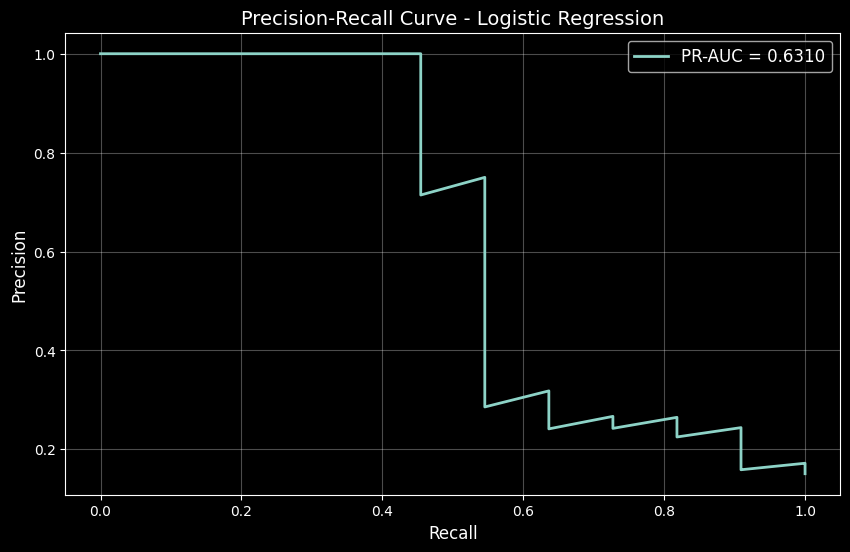

In [134]:
# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Logistic Regression', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('pr_curve_lr.png', dpi=300, bbox_inches='tight')
plt.show()

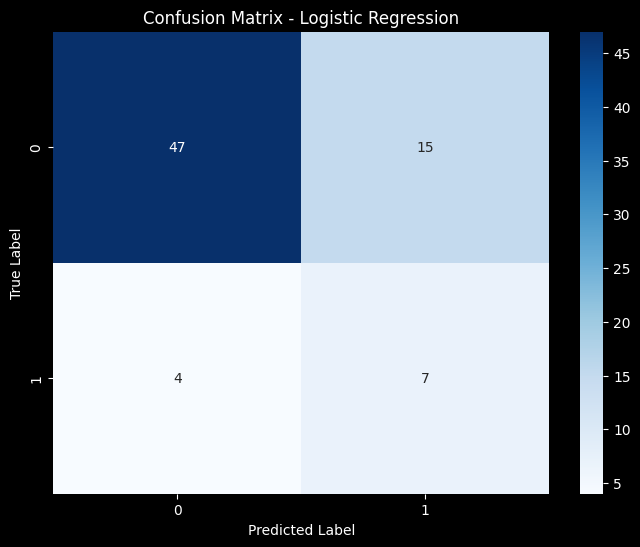

In [135]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_lr.png', dpi=300, bbox_inches='tight')
plt.show()

In [136]:
#XGBoost Production Model

import xgboost as xgb
from xgboost import XGBClassifier

In [137]:
print("\n" + "="*60)
print("PRODUCTION MODEL: XGBoost")
print("="*60)


PRODUCTION MODEL: XGBoost


In [138]:
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")


Scale pos weight: 5.43


In [139]:
# Train XGBoost with class weights (NO SMOTE needed)
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    eval_metric='aucpr',  # Use PR-AUC as metric
    early_stopping_rounds=20,
    n_jobs=-1
)

In [140]:
# Train with validation set for early stopping
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=10
)

[0]	validation_0-aucpr:0.35510
[10]	validation_0-aucpr:0.94886
[20]	validation_0-aucpr:0.99209
[30]	validation_0-aucpr:1.00000
[40]	validation_0-aucpr:1.00000
[43]	validation_0-aucpr:1.00000


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",20
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [141]:
# Predictions
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

In [142]:
# Calculate metrics
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_val_proba_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

print(f"\n📊 XGBoost Validation Results:")
print(f"Precision: {precision_score(y_val, y_val_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba_xgb):.4f}")
print(f"⭐ PR-AUC: {pr_auc_xgb:.4f}")



📊 XGBoost Validation Results:
Precision: 1.0000
Recall: 0.9091
F1-Score: 0.9524
ROC-AUC: 1.0000
⭐ PR-AUC: 1.0000


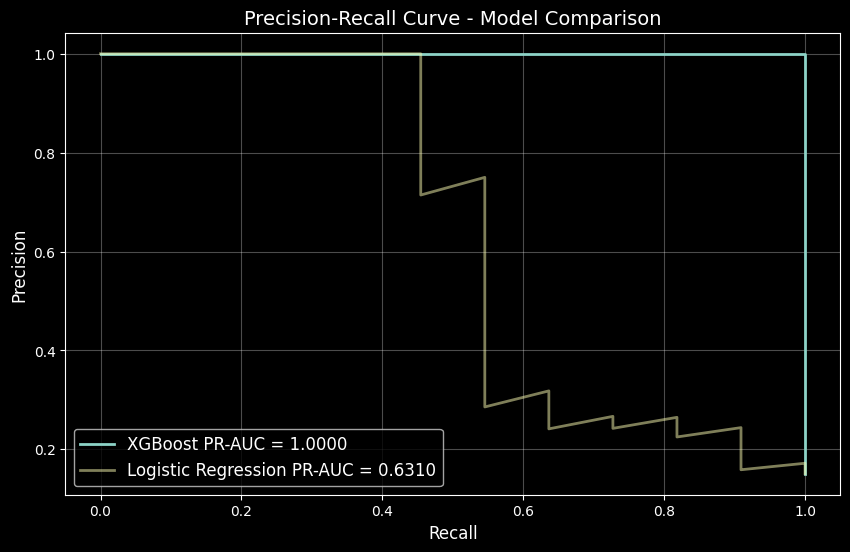

In [143]:
# Plot PR Curve
plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, linewidth=2, label=f'XGBoost PR-AUC = {pr_auc_xgb:.4f}')
plt.plot(recall, precision, linewidth=2, alpha=0.5, label=f'Logistic Regression PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Model Comparison', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('pr_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [144]:

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


📊 Top 10 Most Important Features:
                             Feature  Importance
               distance_from_optimal      0.2142
                  Temperature_Sensor      0.1270
                   Arm_Sensor_ema_1h      0.1213
                     combined_stress      0.0813
           Temperature_Sensor_diff_2      0.0796
                     Pressure_Sensor      0.0770
                 temp_pressure_ratio      0.0625
               Arm_Sensor_pct_change      0.0502
Temperature_Sensor_rolling_median_1h      0.0492
     Vibration_Sensor_rolling_max_1h      0.0489


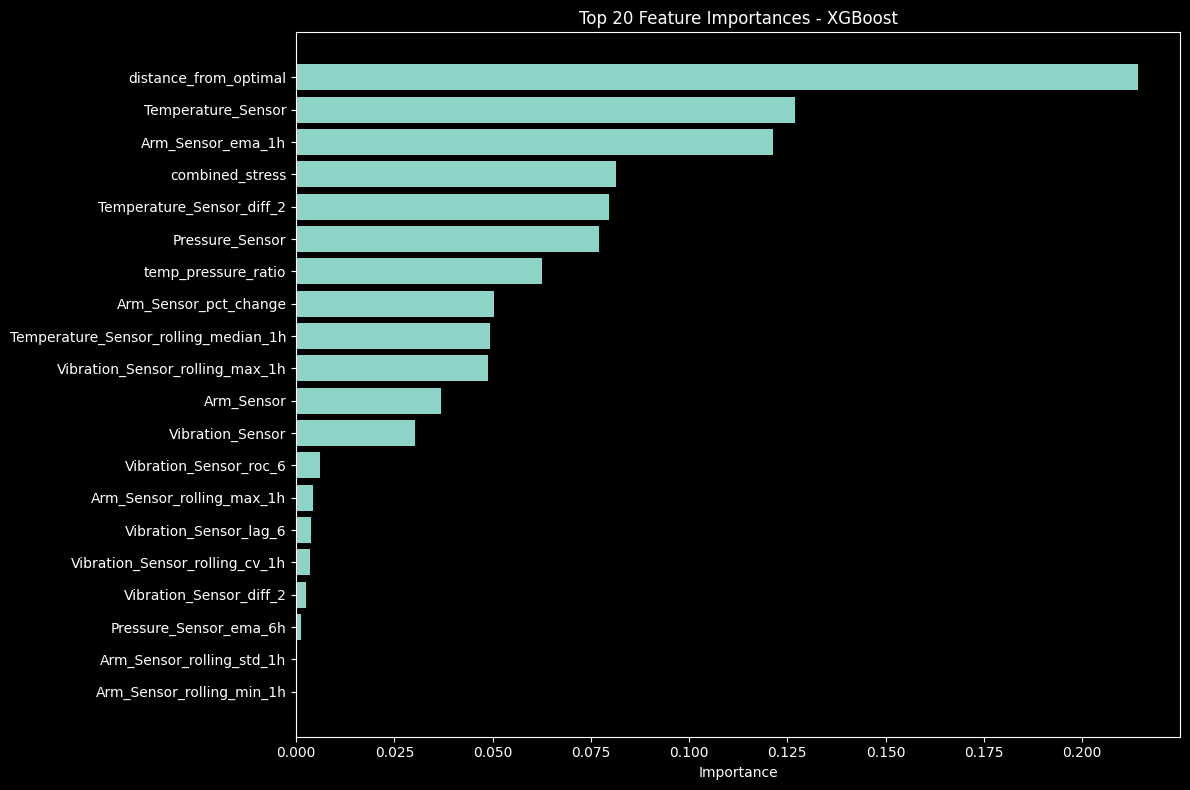

In [145]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'])
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [146]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [147]:
# Optuna Optimization

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances


In [148]:
def objective(trial):
    """
    Optuna objective function for XGBoost
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'eval_metric': 'aucpr',
        'n_jobs': -1
    }

    # Train model
    model = XGBClassifier(**params)
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        verbose=0
    )

    # Predict
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc = auc(recall, precision)

    return pr_auc

In [149]:
# Run Optuna optimization
print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
print("="*60)
print("This will take 10-20 minutes...")


HYPERPARAMETER OPTIMIZATION WITH OPTUNA
This will take 10-20 minutes...


In [150]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-31 15:05:45,530] A new study created in memory with name: no-name-5295b71d-f6d6-45e8-ae06-b049d384969a
Best trial: 0. Best value: 1:   2%|▏         | 1/50 [00:00<00:22,  2.18it/s]

[I 2025-12-31 15:05:45,989] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 453, 'max_depth': 8, 'learning_rate': 0.04572553874658568, 'subsample': 0.756451575545255, 'colsample_bytree': 0.9777261673257189, 'min_child_weight': 5, 'gamma': 3.4029518269754173}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   4%|▍         | 2/50 [00:00<00:20,  2.32it/s]

[I 2025-12-31 15:05:46,402] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 478, 'max_depth': 9, 'learning_rate': 0.05443726977857359, 'subsample': 0.7264054428804313, 'colsample_bytree': 0.732887428777589, 'min_child_weight': 3, 'gamma': 4.9370971979909335}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   6%|▌         | 3/50 [00:01<00:19,  2.37it/s]

[I 2025-12-31 15:05:46,810] Trial 2 finished with value: 0.9368293322838778 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.01759545801845039, 'subsample': 0.965601346423459, 'colsample_bytree': 0.9548650248992399, 'min_child_weight': 10, 'gamma': 0.9103461051575878}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:   8%|▊         | 4/50 [00:01<00:22,  2.02it/s]

[I 2025-12-31 15:05:47,420] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 409, 'max_depth': 10, 'learning_rate': 0.010417941908016481, 'subsample': 0.6521659186046721, 'colsample_bytree': 0.8032973083032402, 'min_child_weight': 3, 'gamma': 4.029350615483439}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  12%|█▏        | 6/50 [00:02<00:13,  3.28it/s]

[I 2025-12-31 15:05:47,611] Trial 4 finished with value: 0.9630739210284665 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.010058775133151784, 'subsample': 0.6029931115572558, 'colsample_bytree': 0.8189491353624815, 'min_child_weight': 9, 'gamma': 4.9768370647721785}. Best is trial 0 with value: 1.0.
[I 2025-12-31 15:05:47,760] Trial 5 finished with value: 0.9738062442607897 and parameters: {'n_estimators': 128, 'max_depth': 8, 'learning_rate': 0.07733267742029175, 'subsample': 0.6545827975059378, 'colsample_bytree': 0.8615288137806649, 'min_child_weight': 7, 'gamma': 2.9633242162002995}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  14%|█▍        | 7/50 [00:02<00:12,  3.50it/s]

[I 2025-12-31 15:05:48,005] Trial 6 finished with value: 0.8997081201626657 and parameters: {'n_estimators': 346, 'max_depth': 6, 'learning_rate': 0.08829556659747288, 'subsample': 0.6643441366825431, 'colsample_bytree': 0.7893844034165836, 'min_child_weight': 8, 'gamma': 4.148388877230915}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  16%|█▌        | 8/50 [00:02<00:12,  3.41it/s]

[I 2025-12-31 15:05:48,317] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 490, 'max_depth': 10, 'learning_rate': 0.11983782591750103, 'subsample': 0.9167724179154788, 'colsample_bytree': 0.8244178080166512, 'min_child_weight': 3, 'gamma': 4.371103368919408}. Best is trial 0 with value: 1.0.
[I 2025-12-31 15:05:48,500] Trial 8 finished with value: 0.9920798898071626 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.13386744440457254, 'subsample': 0.8390460923324293, 'colsample_bytree': 0.9097283748181866, 'min_child_weight': 6, 'gamma': 3.4780677270857945}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  20%|██        | 10/50 [00:03<00:14,  2.73it/s]

[I 2025-12-31 15:05:49,103] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.020844085474490955, 'subsample': 0.7302967802860039, 'colsample_bytree': 0.6647278216073648, 'min_child_weight': 4, 'gamma': 0.4811504846871234}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  22%|██▏       | 11/50 [00:04<00:15,  2.59it/s]

[I 2025-12-31 15:05:49,534] Trial 10 finished with value: 1.0 and parameters: {'n_estimators': 216, 'max_depth': 7, 'learning_rate': 0.04224842366365015, 'subsample': 0.8362560549568574, 'colsample_bytree': 0.9961663382917899, 'min_child_weight': 1, 'gamma': 1.798858027259012}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  24%|██▍       | 12/50 [00:04<00:15,  2.44it/s]

[I 2025-12-31 15:05:50,000] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 498, 'max_depth': 8, 'learning_rate': 0.04542606602483826, 'subsample': 0.7568520787881818, 'colsample_bytree': 0.6894757258737552, 'min_child_weight': 5, 'gamma': 2.2116294765441973}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  26%|██▌       | 13/50 [00:04<00:14,  2.59it/s]

[I 2025-12-31 15:05:50,330] Trial 12 finished with value: 1.0 and parameters: {'n_estimators': 439, 'max_depth': 8, 'learning_rate': 0.21595258689132255, 'subsample': 0.7592200585249035, 'colsample_bytree': 0.7381983121468438, 'min_child_weight': 1, 'gamma': 3.098035429948013}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  28%|██▊       | 14/50 [00:05<00:14,  2.48it/s]

[I 2025-12-31 15:05:50,770] Trial 13 finished with value: 1.0 and parameters: {'n_estimators': 442, 'max_depth': 9, 'learning_rate': 0.030101837690750935, 'subsample': 0.7200499913771636, 'colsample_bytree': 0.7279306285035999, 'min_child_weight': 3, 'gamma': 4.972061590838805}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  30%|███       | 15/50 [00:05<00:13,  2.59it/s]

[I 2025-12-31 15:05:51,119] Trial 14 finished with value: 1.0 and parameters: {'n_estimators': 318, 'max_depth': 7, 'learning_rate': 0.06709811059617206, 'subsample': 0.8095498135626621, 'colsample_bytree': 0.6042994794337712, 'min_child_weight': 5, 'gamma': 1.7792081554240813}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  32%|███▏      | 16/50 [00:06<00:13,  2.51it/s]

[I 2025-12-31 15:05:51,545] Trial 15 finished with value: 1.0 and parameters: {'n_estimators': 449, 'max_depth': 9, 'learning_rate': 0.028364026143482324, 'subsample': 0.8786643612516901, 'colsample_bytree': 0.8875979583824662, 'min_child_weight': 2, 'gamma': 3.605082078566912}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  34%|███▍      | 17/50 [00:06<00:11,  2.91it/s]

[I 2025-12-31 15:05:51,765] Trial 16 finished with value: 0.8731929686475142 and parameters: {'n_estimators': 371, 'max_depth': 3, 'learning_rate': 0.2598055943738699, 'subsample': 0.7036784882737128, 'colsample_bytree': 0.7568156958852872, 'min_child_weight': 6, 'gamma': 2.6650658453142277}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  36%|███▌      | 18/50 [00:06<00:11,  2.89it/s]

[I 2025-12-31 15:05:52,118] Trial 17 finished with value: 1.0 and parameters: {'n_estimators': 473, 'max_depth': 6, 'learning_rate': 0.04897490850872612, 'subsample': 0.7820321464155339, 'colsample_bytree': 0.9392482532414181, 'min_child_weight': 4, 'gamma': 4.343255772896946}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  38%|███▊      | 19/50 [00:06<00:10,  2.94it/s]

[I 2025-12-31 15:05:52,442] Trial 18 finished with value: 1.0 and parameters: {'n_estimators': 406, 'max_depth': 10, 'learning_rate': 0.03563911098369932, 'subsample': 0.692087107112752, 'colsample_bytree': 0.6495412492622046, 'min_child_weight': 4, 'gamma': 3.5236985693435976}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  40%|████      | 20/50 [00:07<00:09,  3.30it/s]

[I 2025-12-31 15:05:52,659] Trial 19 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.12149674443255142, 'subsample': 0.613341535057013, 'colsample_bytree': 0.970023521821228, 'min_child_weight': 2, 'gamma': 1.218298749680871}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  42%|████▏     | 21/50 [00:07<00:09,  3.19it/s]

[I 2025-12-31 15:05:52,995] Trial 20 finished with value: 1.0 and parameters: {'n_estimators': 323, 'max_depth': 7, 'learning_rate': 0.020310919295803042, 'subsample': 0.8026018698402257, 'colsample_bytree': 0.8577564209740038, 'min_child_weight': 7, 'gamma': 4.678551477215315}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  44%|████▍     | 22/50 [00:08<00:10,  2.61it/s]

[I 2025-12-31 15:05:53,540] Trial 21 finished with value: 1.0 and parameters: {'n_estimators': 408, 'max_depth': 10, 'learning_rate': 0.011088373112743797, 'subsample': 0.657945112199653, 'colsample_bytree': 0.7689941335799678, 'min_child_weight': 3, 'gamma': 3.931394666474689}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  46%|████▌     | 23/50 [00:08<00:09,  2.73it/s]

[I 2025-12-31 15:05:53,868] Trial 22 finished with value: 1.0 and parameters: {'n_estimators': 413, 'max_depth': 9, 'learning_rate': 0.06027686068147411, 'subsample': 0.746592443771624, 'colsample_bytree': 0.6972542305415109, 'min_child_weight': 2, 'gamma': 3.7878714266438007}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  48%|████▊     | 24/50 [00:08<00:10,  2.38it/s]

[I 2025-12-31 15:05:54,414] Trial 23 finished with value: 1.0 and parameters: {'n_estimators': 467, 'max_depth': 10, 'learning_rate': 0.013899406171308191, 'subsample': 0.6788725582565049, 'colsample_bytree': 0.6065828554498529, 'min_child_weight': 4, 'gamma': 3.1657294279219443}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  50%|█████     | 25/50 [00:09<00:10,  2.42it/s]

[I 2025-12-31 15:05:54,811] Trial 24 finished with value: 1.0 and parameters: {'n_estimators': 381, 'max_depth': 9, 'learning_rate': 0.02384169171070032, 'subsample': 0.6292973751481394, 'colsample_bytree': 0.7974521122306499, 'min_child_weight': 5, 'gamma': 4.313540624552148}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  52%|█████▏    | 26/50 [00:09<00:09,  2.58it/s]

[I 2025-12-31 15:05:55,140] Trial 25 finished with value: 1.0 and parameters: {'n_estimators': 428, 'max_depth': 8, 'learning_rate': 0.18259472488286385, 'subsample': 0.7060562009877909, 'colsample_bytree': 0.71879027342028, 'min_child_weight': 3, 'gamma': 4.569478547277372}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  54%|█████▍    | 27/50 [00:09<00:08,  2.62it/s]

[I 2025-12-31 15:05:55,509] Trial 26 finished with value: 1.0 and parameters: {'n_estimators': 466, 'max_depth': 10, 'learning_rate': 0.09387677161741215, 'subsample': 0.6351705044231037, 'colsample_bytree': 0.8558874371636194, 'min_child_weight': 2, 'gamma': 4.003736097141809}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  56%|█████▌    | 28/50 [00:10<00:09,  2.32it/s]

[I 2025-12-31 15:05:56,051] Trial 27 finished with value: 1.0 and parameters: {'n_estimators': 358, 'max_depth': 9, 'learning_rate': 0.015604540212696263, 'subsample': 0.7759792167925984, 'colsample_bytree': 0.9122162150697322, 'min_child_weight': 6, 'gamma': 2.604002568895158}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  58%|█████▊    | 29/50 [00:10<00:08,  2.53it/s]

[I 2025-12-31 15:05:56,367] Trial 28 finished with value: 1.0 and parameters: {'n_estimators': 398, 'max_depth': 8, 'learning_rate': 0.03740766689595709, 'subsample': 0.7402036540226686, 'colsample_bytree': 0.6459693228379226, 'min_child_weight': 4, 'gamma': 4.744998594374644}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  60%|██████    | 30/50 [00:11<00:06,  2.87it/s]

[I 2025-12-31 15:05:56,609] Trial 29 finished with value: 0.9201626656172112 and parameters: {'n_estimators': 278, 'max_depth': 10, 'learning_rate': 0.05550396366854464, 'subsample': 0.8354975057868144, 'colsample_bytree': 0.9963021468686202, 'min_child_weight': 10, 'gamma': 3.3744040505192325}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  62%|██████▏   | 31/50 [00:11<00:06,  2.80it/s]

[I 2025-12-31 15:05:56,983] Trial 30 finished with value: 0.9671575898848627 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.16278808071918627, 'subsample': 0.9789512492273471, 'colsample_bytree': 0.9469333269297098, 'min_child_weight': 7, 'gamma': 0.0093478387924959}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  64%|██████▍   | 32/50 [00:11<00:06,  2.62it/s]

[I 2025-12-31 15:05:57,421] Trial 31 finished with value: 1.0 and parameters: {'n_estimators': 480, 'max_depth': 10, 'learning_rate': 0.11086442573401818, 'subsample': 0.92438380169224, 'colsample_bytree': 0.8370088694633261, 'min_child_weight': 3, 'gamma': 4.467501624385164}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  66%|██████▌   | 33/50 [00:12<00:06,  2.56it/s]

[I 2025-12-31 15:05:57,834] Trial 32 finished with value: 1.0 and parameters: {'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.07581102542213705, 'subsample': 0.9433883622530778, 'colsample_bytree': 0.8176824835054812, 'min_child_weight': 3, 'gamma': 4.996752660258714}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  68%|██████▊   | 34/50 [00:12<00:05,  2.77it/s]

[I 2025-12-31 15:05:58,122] Trial 33 finished with value: 1.0 and parameters: {'n_estimators': 499, 'max_depth': 10, 'learning_rate': 0.2984806499471687, 'subsample': 0.8852521516190582, 'colsample_bytree': 0.8239922536239591, 'min_child_weight': 1, 'gamma': 4.05697015593112}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  70%|███████   | 35/50 [00:12<00:05,  2.97it/s]

[I 2025-12-31 15:05:58,405] Trial 34 finished with value: 0.9834022038567493 and parameters: {'n_estimators': 421, 'max_depth': 9, 'learning_rate': 0.09249141070324413, 'subsample': 0.9027295046563868, 'colsample_bytree': 0.7599082227835199, 'min_child_weight': 9, 'gamma': 4.25982004959739}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  72%|███████▏  | 36/50 [00:13<00:04,  3.10it/s]

[I 2025-12-31 15:05:58,695] Trial 35 finished with value: 1.0 and parameters: {'n_estimators': 473, 'max_depth': 10, 'learning_rate': 0.15859129713102166, 'subsample': 0.9956359368588448, 'colsample_bytree': 0.7886087565738007, 'min_child_weight': 5, 'gamma': 3.835685081784036}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  74%|███████▍  | 37/50 [00:13<00:05,  2.49it/s]

[I 2025-12-31 15:05:59,282] Trial 36 finished with value: 1.0 and parameters: {'n_estimators': 339, 'max_depth': 8, 'learning_rate': 0.01188143776697589, 'subsample': 0.6801234412755561, 'colsample_bytree': 0.8783133055177494, 'min_child_weight': 2, 'gamma': 2.870443308774806}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  76%|███████▌  | 38/50 [00:13<00:04,  2.85it/s]

[I 2025-12-31 15:05:59,509] Trial 37 finished with value: 1.0 and parameters: {'n_estimators': 223, 'max_depth': 6, 'learning_rate': 0.07290210557246425, 'subsample': 0.8657630445907453, 'colsample_bytree': 0.7786000379177057, 'min_child_weight': 4, 'gamma': 4.599745407864613}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  78%|███████▊  | 39/50 [00:14<00:04,  2.67it/s]

[I 2025-12-31 15:05:59,944] Trial 38 finished with value: 1.0 and parameters: {'n_estimators': 453, 'max_depth': 9, 'learning_rate': 0.02927448689357811, 'subsample': 0.726848516495423, 'colsample_bytree': 0.9155978164363381, 'min_child_weight': 3, 'gamma': 4.830141458903105}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  80%|████████  | 40/50 [00:14<00:03,  2.62it/s]

[I 2025-12-31 15:06:00,343] Trial 39 finished with value: 1.0 and parameters: {'n_estimators': 393, 'max_depth': 5, 'learning_rate': 0.0526862218948418, 'subsample': 0.8199975987873472, 'colsample_bytree': 0.8046235664218078, 'min_child_weight': 1, 'gamma': 4.130448696430303}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  82%|████████▏ | 41/50 [00:15<00:03,  2.93it/s]

[I 2025-12-31 15:06:00,588] Trial 40 finished with value: 1.0 and parameters: {'n_estimators': 139, 'max_depth': 10, 'learning_rate': 0.03889519413753832, 'subsample': 0.7709647183301334, 'colsample_bytree': 0.7436619653266446, 'min_child_weight': 6, 'gamma': 3.285477704376915}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  84%|████████▍ | 42/50 [00:15<00:03,  2.14it/s]

[I 2025-12-31 15:06:01,352] Trial 41 finished with value: 1.0 and parameters: {'n_estimators': 425, 'max_depth': 9, 'learning_rate': 0.022818252783017964, 'subsample': 0.729802112158547, 'colsample_bytree': 0.6655483913181318, 'min_child_weight': 4, 'gamma': 0.500830586211956}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  86%|████████▌ | 43/50 [00:16<00:03,  2.12it/s]

[I 2025-12-31 15:06:01,833] Trial 42 finished with value: 1.0 and parameters: {'n_estimators': 482, 'max_depth': 9, 'learning_rate': 0.018083813451182106, 'subsample': 0.7857654235319659, 'colsample_bytree': 0.7040357973203951, 'min_child_weight': 5, 'gamma': 2.344863681969055}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  88%|████████▊ | 44/50 [00:16<00:02,  2.03it/s]

[I 2025-12-31 15:06:02,370] Trial 43 finished with value: 1.0 and parameters: {'n_estimators': 375, 'max_depth': 8, 'learning_rate': 0.01500258761264315, 'subsample': 0.7109538589108835, 'colsample_bytree': 0.6572894431304012, 'min_child_weight': 3, 'gamma': 1.4043782437808552}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  90%|█████████ | 45/50 [00:17<00:02,  2.18it/s]

[I 2025-12-31 15:06:02,750] Trial 44 finished with value: 1.0 and parameters: {'n_estimators': 435, 'max_depth': 9, 'learning_rate': 0.02524467752692983, 'subsample': 0.7587744876565934, 'colsample_bytree': 0.625801122528897, 'min_child_weight': 4, 'gamma': 2.0473036729470317}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  92%|█████████▏| 46/50 [00:17<00:01,  2.36it/s]

[I 2025-12-31 15:06:03,094] Trial 45 finished with value: 1.0 and parameters: {'n_estimators': 459, 'max_depth': 8, 'learning_rate': 0.032142377346236546, 'subsample': 0.6474399985195041, 'colsample_bytree': 0.6716494998866023, 'min_child_weight': 5, 'gamma': 3.63912231775849}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  94%|█████████▍| 47/50 [00:18<00:01,  2.00it/s]

[I 2025-12-31 15:06:03,772] Trial 46 finished with value: 1.0 and parameters: {'n_estimators': 488, 'max_depth': 10, 'learning_rate': 0.013074013340007228, 'subsample': 0.6792946753212925, 'colsample_bytree': 0.7107933652541691, 'min_child_weight': 3, 'gamma': 0.6759539299040266}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  96%|█████████▌| 48/50 [00:18<00:01,  1.84it/s]

[I 2025-12-31 15:06:04,421] Trial 47 finished with value: 1.0 and parameters: {'n_estimators': 443, 'max_depth': 7, 'learning_rate': 0.010057912224858067, 'subsample': 0.603798107581601, 'colsample_bytree': 0.6820908559877193, 'min_child_weight': 4, 'gamma': 2.895874487057375}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1:  98%|█████████▊| 49/50 [00:19<00:00,  2.05it/s]

[I 2025-12-31 15:06:04,779] Trial 48 finished with value: 1.0 and parameters: {'n_estimators': 361, 'max_depth': 3, 'learning_rate': 0.042697500960967034, 'subsample': 0.8491226576291547, 'colsample_bytree': 0.7327158491512797, 'min_child_weight': 2, 'gamma': 0.12571750913650304}. Best is trial 0 with value: 1.0.


Best trial: 0. Best value: 1: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]

[I 2025-12-31 15:06:05,028] Trial 49 finished with value: 0.9630739210284665 and parameters: {'n_estimators': 295, 'max_depth': 9, 'learning_rate': 0.06191083482610175, 'subsample': 0.7953032087149708, 'colsample_bytree': 0.9751795276468593, 'min_child_weight': 8, 'gamma': 4.388031436070516}. Best is trial 0 with value: 1.0.


In [151]:
print(f"\n✅ Optimization complete!")
print(f"Best PR-AUC: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


✅ Optimization complete!
Best PR-AUC: 1.0000

Best parameters:
  n_estimators: 453
  max_depth: 8
  learning_rate: 0.04572553874658568
  subsample: 0.756451575545255
  colsample_bytree: 0.9777261673257189
  min_child_weight: 5
  gamma: 3.4029518269754173


In [152]:
# Train final model with best parameters
best_params = study.best_params
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = 42
best_params['eval_metric'] = 'aucpr'
best_params['n_jobs'] = -1

final_xgb_model = XGBClassifier(**best_params)
final_xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=10
)

[0]	validation_0-aucpr:0.66630
[10]	validation_0-aucpr:0.94538
[20]	validation_0-aucpr:0.99209
[30]	validation_0-aucpr:1.00000
[40]	validation_0-aucpr:1.00000
[50]	validation_0-aucpr:1.00000
[60]	validation_0-aucpr:1.00000
[70]	validation_0-aucpr:1.00000
[80]	validation_0-aucpr:1.00000
[90]	validation_0-aucpr:1.00000
[100]	validation_0-aucpr:1.00000
[110]	validation_0-aucpr:1.00000
[120]	validation_0-aucpr:1.00000
[130]	validation_0-aucpr:1.00000
[140]	validation_0-aucpr:1.00000
[150]	validation_0-aucpr:1.00000
[160]	validation_0-aucpr:1.00000
[170]	validation_0-aucpr:1.00000
[180]	validation_0-aucpr:1.00000
[190]	validation_0-aucpr:1.00000
[200]	validation_0-aucpr:1.00000
[210]	validation_0-aucpr:1.00000
[220]	validation_0-aucpr:1.00000
[230]	validation_0-aucpr:1.00000
[240]	validation_0-aucpr:1.00000
[250]	validation_0-aucpr:1.00000
[260]	validation_0-aucpr:1.00000
[270]	validation_0-aucpr:1.00000
[280]	validation_0-aucpr:1.00000
[290]	validation_0-aucpr:1.00000
[300]	validation_0-au

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9777261673257189
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import 

In [153]:
# Evaluate final model
y_val_pred_final = final_xgb_model.predict(X_val_scaled)
y_val_proba_final = final_xgb_model.predict_proba(X_val_scaled)[:, 1]

In [154]:
precision_final, recall_final, _ = precision_recall_curve(y_val, y_val_proba_final)
pr_auc_final = auc(recall_final, precision_final)

In [155]:
print(f"\n📊 FINAL MODEL Validation Results:")
print(f"Precision: {precision_score(y_val, y_val_pred_final):.4f} (minimize false alarms)")
print(f"Recall: {recall_score(y_val, y_val_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_final):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba_final):.4f}")
print(f"⭐ PR-AUC: {pr_auc_final:.4f}")


📊 FINAL MODEL Validation Results:
Precision: 0.9167 (minimize false alarms)
Recall: 1.0000
F1-Score: 0.9565
ROC-AUC: 1.0000
⭐ PR-AUC: 1.0000


In [156]:
# Save final model
joblib.dump(final_xgb_model, 'xgboost_final_model.pkl')
print("\n✅ Final model saved: xgboost_final_model.pkl")


✅ Final model saved: xgboost_final_model.pkl


Shap Explainability

In [158]:
#SHAP Explainability Implementation

import shap
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [159]:
final_model = joblib.load('xgboost_final_model.pkl')
scaler = joblib.load('scaler.pkl')

In [160]:
print("="*60)
print("WEEK 3: MODEL EXPLAINABILITY WITH SHAP")
print("="*60)

WEEK 3: MODEL EXPLAINABILITY WITH SHAP


In [161]:
# Create SHAP explainer
print("\n🔍 Creating SHAP explainer (this may take a few minutes)...")
explainer = shap.TreeExplainer(final_model)


🔍 Creating SHAP explainer (this may take a few minutes)...


In [162]:
# Calculate SHAP values for validation set
# Use a sample if dataset is too large (for speed)
sample_size = min(1000, len(X_val_scaled))
X_val_sample = X_val_scaled[:sample_size]

In [163]:
print(f"Calculating SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_val_sample)

print("✅ SHAP values calculated!")

Calculating SHAP values for 73 samples...
✅ SHAP values calculated!


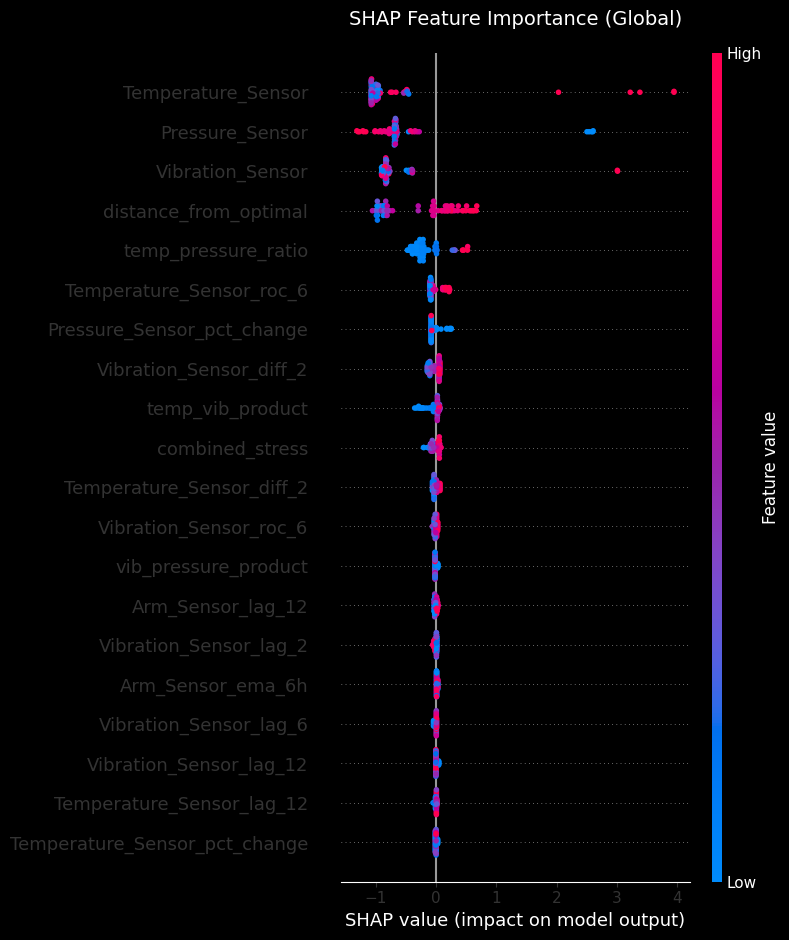

✅ Saved: shap_global_importance.png


In [164]:
# Summary plot - shows importance and impact of all features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_sample,
                 feature_names=feature_columns,
                 show=False)
plt.title('SHAP Feature Importance (Global)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_global_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: shap_global_importance.png")

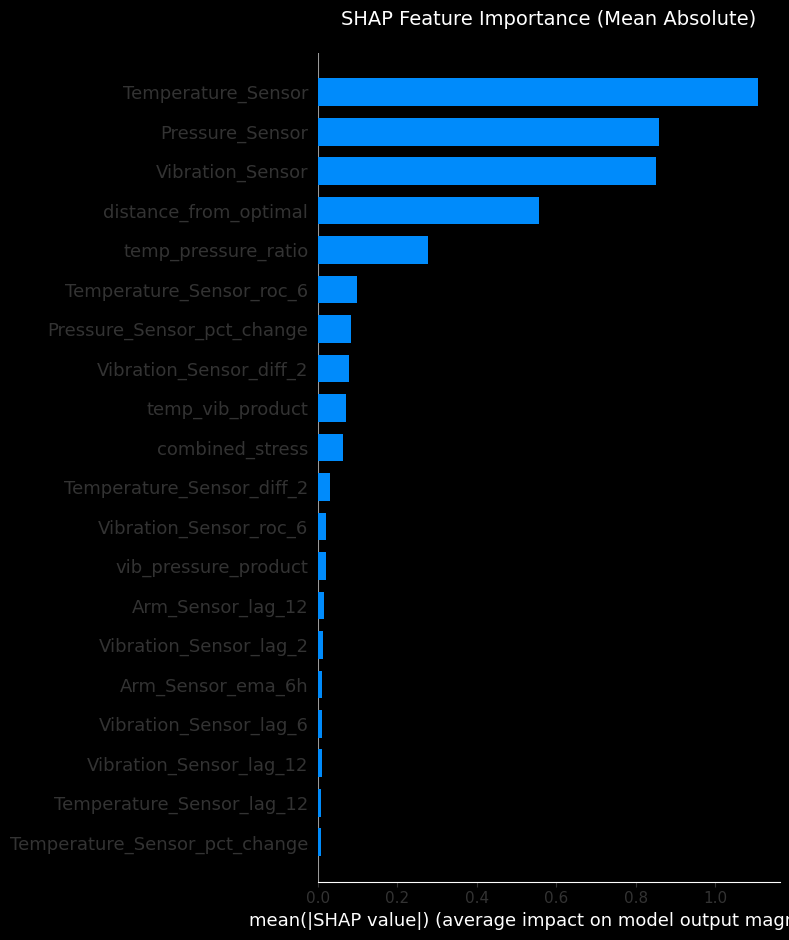

✅ Saved: shap_bar_importance.png


In [165]:
# Bar plot - average absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_sample,
                 feature_names=feature_columns,
                 plot_type="bar",
                 show=False)
plt.title('SHAP Feature Importance (Mean Absolute)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('shap_bar_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: shap_bar_importance.png")

In [166]:
# 2. LOCAL EXPLANATIONS - Individual Predictions
print("\n" + "="*60)
print("LOCAL EXPLANATIONS - Why did the model predict failure?")
print("="*60)


LOCAL EXPLANATIONS - Why did the model predict failure?


In [167]:
# Find a failure prediction to explain
failure_indices = np.where(final_model.predict(X_val_sample) == 1)[0]


Explaining prediction for sample 13:
Predicted: FAILURE
Probability: 0.9527


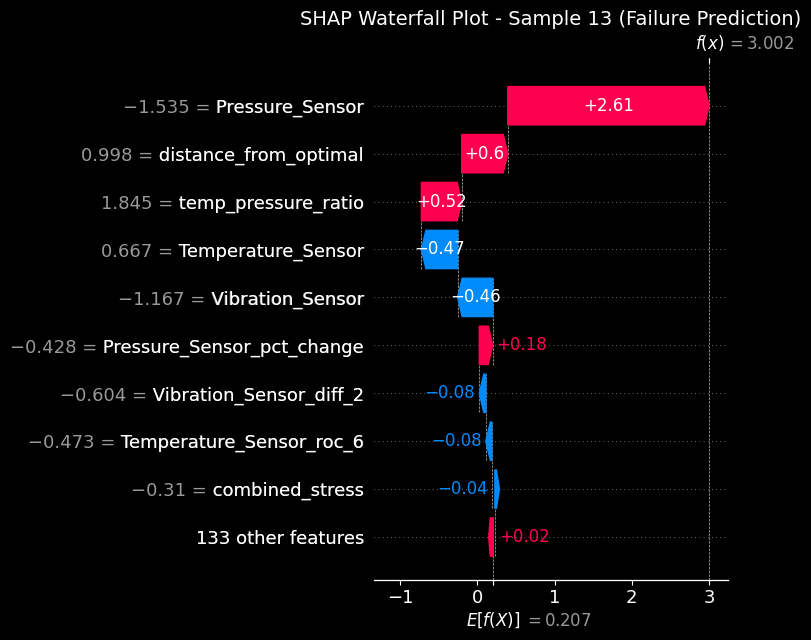

✅ Saved: shap_waterfall_sample_13.png


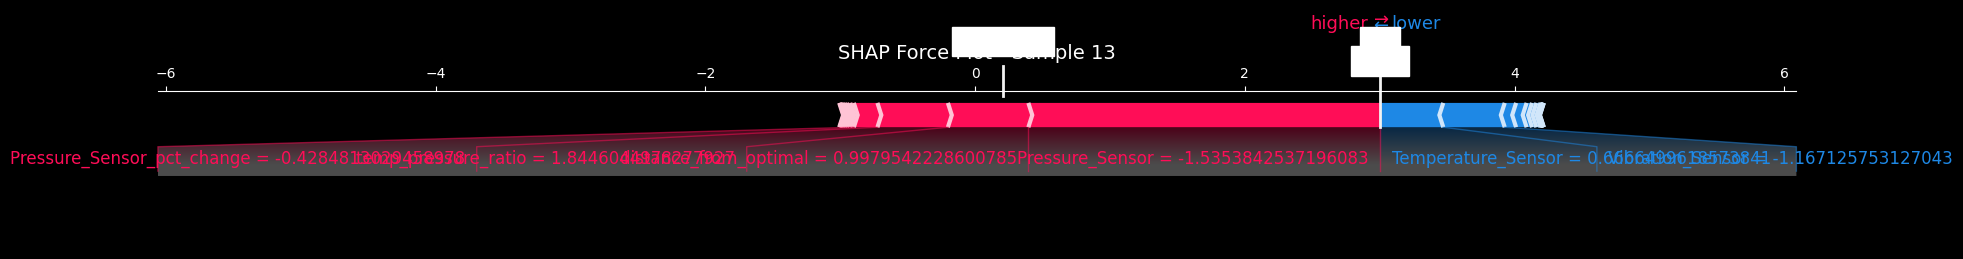

✅ Saved: shap_force_sample_13.png

📊 Top Contributing Features:
                   Feature   Value  SHAP_Value
           Pressure_Sensor -1.5354      2.6077
     distance_from_optimal  0.9980      0.5967
       temp_pressure_ratio  1.8446      0.5224
        Temperature_Sensor  0.6666     -0.4689
          Vibration_Sensor -1.1671     -0.4558
Pressure_Sensor_pct_change -0.4285      0.1750
   Vibration_Sensor_diff_2 -0.6043     -0.0843
  Temperature_Sensor_roc_6 -0.4726     -0.0779
           combined_stress -0.3100     -0.0402
 Temperature_Sensor_diff_2 -0.0408     -0.0321

💬 EXPLANATION FOR MAINTENANCE ENGINEER:
------------------------------------------------------------
------------------------------------------------------------


In [168]:
if len(failure_indices) > 0:
    # Explain the first failure prediction
    idx = failure_indices[0]

    print(f"\nExplaining prediction for sample {idx}:")
    print(f"Predicted: FAILURE")
    print(f"Probability: {final_model.predict_proba(X_val_sample)[idx, 1]:.4f}")

    # Waterfall plot - shows how each feature contributes
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_val_sample[idx],
        feature_names=feature_columns
    ), show=False)
    plt.title(f'SHAP Waterfall Plot - Sample {idx} (Failure Prediction)', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_sample_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved: shap_waterfall_sample_{idx}.png")

    # Force plot - shows contribution of each feature
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_val_sample[idx],
        feature_names=feature_columns,
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Sample {idx}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'shap_force_sample_{idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved: shap_force_sample_{idx}.png")

    # Create human-readable explanation
    feature_contributions = pd.DataFrame({
        'Feature': feature_columns,
        'Value': X_val_sample[idx],
        'SHAP_Value': shap_values[idx]
    }).sort_values('SHAP_Value', key=abs, ascending=False)

    print("\n📊 Top Contributing Features:")
    print(feature_contributions.head(10).to_string(index=False))

    # Generate natural language explanation
    print("\n💬 EXPLANATION FOR MAINTENANCE ENGINEER:")
    print("-" * 60)

    top_features = feature_contributions.head(5)
    explanation_parts = []

    for _, row in top_features.iterrows():
        feature = row['Feature']
        value = row['Value']
        shap_val = row['SHAP_Value']

        if 'rolling_mean' in feature:
            explanation_parts.append(
                f"• The rolling average of {feature.split('_')[0]} "
                f"is {value:.2f}, which {'increases' if shap_val > 0 else 'decreases'} "
                f"failure risk significantly."
            )
        elif 'temperature' in feature:
            explanation_parts.append(
                f"• Temperature reading ({value:.2f}°C) "
                f"{'exceeds safe operating limits' if shap_val > 0 else 'is within normal range'}."
            )
        elif 'vibration' in feature:
            explanation_parts.append(
                f"• Vibration level ({value:.2f} Hz) "
                f"{'indicates mechanical stress' if shap_val > 0 else 'is normal'}."
            )
        elif 'rolling_std' in feature:
            explanation_parts.append(
                f"• High variability detected in {feature.split('_')[0]} "
                f"(std={value:.2f}), suggesting unstable conditions."
            )

    for part in explanation_parts:
        print(part)

    print("-" * 60)
else:
    print("No failure predictions found in sample.")

In [169]:
# 3. DEPENDENCE PLOTS - Show relationship between features
print("\n" + "="*60)
print("SHAP DEPENDENCE PLOTS")
print("="*60)


SHAP DEPENDENCE PLOTS


In [170]:
# Plot for top 3 most important features
top_3_features = feature_importance.head(3)['Feature'].tolist()

<Figure size 1000x600 with 0 Axes>

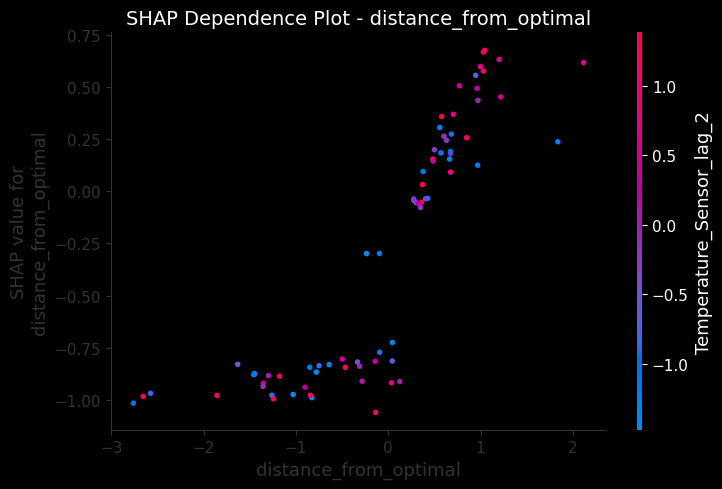

✅ Saved: shap_dependence_distance_from_optimal.png


<Figure size 1000x600 with 0 Axes>

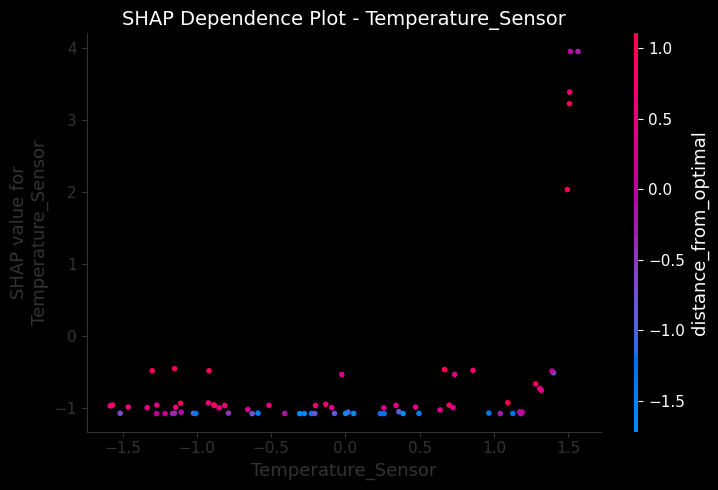

✅ Saved: shap_dependence_Temperature_Sensor.png


<Figure size 1000x600 with 0 Axes>

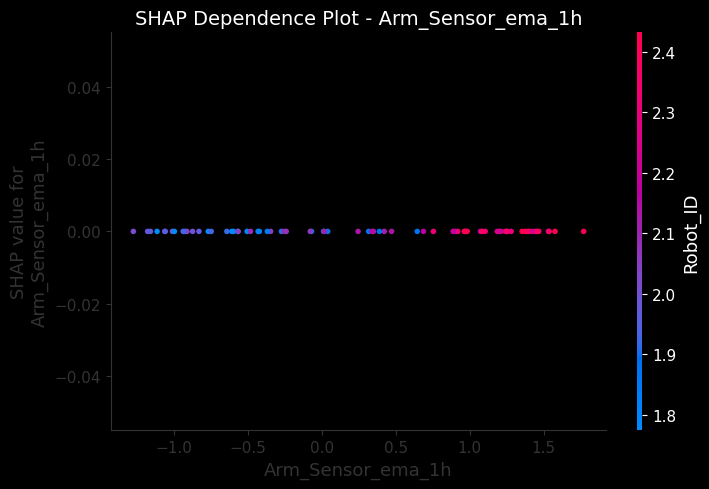

✅ Saved: shap_dependence_Arm_Sensor_ema_1h.png


In [171]:
for i, feature in enumerate(top_3_features):
    if feature in feature_columns:
        feature_idx = feature_columns.index(feature)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X_val_sample,
            feature_names=feature_columns,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✅ Saved: shap_dependence_{feature}.png")
